In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**9. In this exercise, we will predict the number of applications received
using the other variables in the College data set.
(a) Split the data set into a training set and a test set.**

In [3]:
college = pd.read_csv("data/College.csv").set_index('Unnamed: 0')
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Unnamed: 0,,,,,,,,,,,,,,,,,,
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [4]:
#patsy.dmatrices不支持列名含.，将其转化为_
college_prefix = college.copy()
for column_value in college.columns:
    if '.' in column_value:
        column_value_replace = column_value.replace(".", "_")
        college_prefix.rename(columns={column_value:column_value_replace},inplace=True)
#这里使用pd.get_dummies进行哑变量变换，主要为使用patsy.dmatrices会多出一个变量，也可以在模型中使用'1+...'
dummies = pd.get_dummies(college_prefix['Private'], prefix='Private')
college_prefix = college_prefix.join(dummies).drop('Private',axis=1).drop('Private_No',axis=1)

In [5]:
columns_value = '0'
for column_value in college_prefix.columns:
    columns_value = columns_value + '+' + column_value
model = 'Apps ~ {} - Apps'.format(columns_value)
y,X = patsy.dmatrices(model, data = college_prefix, return_type="dataframe")

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

**(b) Fit a linear model using least squares on the training set, and
report the test error obtained.**

In [7]:
lin = linear_model.LinearRegression()
lin.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
from sklearn.metrics import mean_squared_error
y_predictions_ols = lin.predict(X_test)
lin_mse = mean_squared_error(y_test, y_predictions_ols)
lin_mse

1452824.8190075099

**(c) Fit a ridge regression model on the training set, with λ chosen
by cross-validation. Report the test error obtained.**

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_train)
X_train_Standard = std_scaler.transform(X_train)
param_grid = [
{'alpha': 10 ** np.linspace(10, -10, 1000) },
]
ridge_reg = Ridge(random_state = 1)
grid_search = GridSearchCV(ridge_reg, param_grid, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=1,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+10, 9.54948564e+09, 9.11926760e+09, 8.70843150e+09,
       8.31610415e+09, 7.94145172e+09, 7.58367791e+09, 7.24202233e+09,
       6.91575883e+...
       2.40093488e-10, 2.29276931e-10, 2.18947676e-10, 2.09083769e-10,
       1.99664245e-10, 1.90669084e-10, 1.82079168e-10, 1.73876240e-10,
       1.66042866e-10, 1.58562396e-10, 1.51418933e-10, 1.44597292e-10,
       1.38082977e-10, 1.31862140e-10, 1.25921561e-10, 1.20248614e-10,
       1.14831241e-10, 1.09657929e-10, 1.04717682e-10, 1.00000000e-10])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

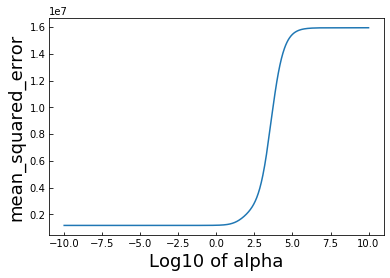

In [10]:
plt.plot(np.linspace(10, -10, 1000),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [11]:
grid_search.best_params_

{'alpha': 1e-10}

In [12]:
X_test_Standard = std_scaler.transform(X_test)
y_predictions_ridge = grid_search.predict(X_test_Standard)
lin_mse = mean_squared_error(y_test, y_predictions_ridge)
lin_mse

1452824.8190038241

从解题过程来看RIDGE是的最佳alpha是无限靠近0（逼近OLS），所以MSE差于OLS也是正常的

**(d) Fit a lasso model on the training set, with λ chosen by cross-
validation. Report the test error obtained, along with the num-
ber of non-zero coefficient estimates.**

In [13]:
lasso_reg = Ridge(random_state = 1)
grid_search = GridSearchCV(lasso_reg, param_grid, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=1,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+10, 9.54948564e+09, 9.11926760e+09, 8.70843150e+09,
       8.31610415e+09, 7.94145172e+09, 7.58367791e+09, 7.24202233e+09,
       6.91575883e+...
       2.40093488e-10, 2.29276931e-10, 2.18947676e-10, 2.09083769e-10,
       1.99664245e-10, 1.90669084e-10, 1.82079168e-10, 1.73876240e-10,
       1.66042866e-10, 1.58562396e-10, 1.51418933e-10, 1.44597292e-10,
       1.38082977e-10, 1.31862140e-10, 1.25921561e-10, 1.20248614e-10,
       1.14831241e-10, 1.09657929e-10, 1.04717682e-10, 1.00000000e-10])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

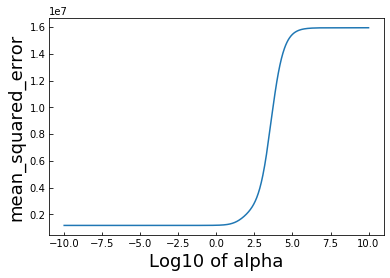

In [14]:
plt.plot(np.linspace(10, -10, 1000),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [15]:
grid_search.best_params_

{'alpha': 1e-10}

In [16]:
X_test_Standard = std_scaler.transform(X_test)
y_predictions_lasso = grid_search.predict(X_test_Standard)
lin_mse = mean_squared_error(y_test, y_predictions_lasso)
lin_mse

1452824.8190038241

从解题过程来看LASSO是的最佳alpha是无限靠近0（逼近OLS），所以MSE差于OLS也是正常的

In [17]:
def get_shrinkage_mod(X,y,grid,methods = 1,return_type = 1):
    std_scaler = StandardScaler(with_mean = False)
    std_scaler.fit(X)
    X_Standard = std_scaler.transform(X)
    shrinkage_mod =  []
    idx = 1
    shrinkage_mod_columns = [['idx','lambda','coef'],['','','Intercept']]
    for variable in X.columns:
        shrinkage_mod_columns[0].append('coef')
        shrinkage_mod_columns[1].append(variable)
    for alpha in grid:
        if methods == 1:
            shrinkage_reg = Ridge(alpha = alpha)
        else:
            shrinkage_reg = Lasso(alpha = alpha)           
        shrinkage_reg.fit(X_Standard,y)
        shrinkage_mod.append([])
        shrinkage_mod[idx - 1].append(idx)
        shrinkage_mod[idx - 1].append(alpha)
        shrinkage_mod[idx - 1].append(shrinkage_reg.intercept_[0])
        #return_type为1返回Standardized Coefficients，否则反馈原模型的Coefficients
        if return_type == 1:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_[0])
            else:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_)
        else:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_[0].reshape(1,-1))[0].tolist())
            else:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_.reshape(1,-1))[0].tolist())
        idx += 1
    return  pd.DataFrame(np.array(shrinkage_mod),columns = shrinkage_mod_columns).set_index('idx')

In [18]:
lasso_mod = get_shrinkage_mod(X_train,y_train,[grid_search.best_params_['alpha']],methods = 2,return_type = 2)

In [19]:
lasso_mod['coef'].iloc[0][lasso_mod['coef'].iloc[0] != 0]

Intercept     -930.268501
Accept           1.674752
Enroll          -1.419212
Top10perc       58.722145
Top25perc      -21.045089
F_Undergrad      0.122187
P_Undergrad      0.044616
Outstate        -0.105442
Room_Board       0.180751
Books           -0.077827
Personal         0.121473
PhD             -8.721830
Terminal        -1.504576
S_F_Ratio       26.681287
perc_alumni      2.988734
Expend           0.094001
Grad_Rate        9.767963
Private_Yes   -389.819181
Name: 1.0, dtype: float64

In [20]:
len(lasso_mod['coef'].iloc[0][lasso_mod['coef'].iloc[0] != 0])

18

**(e) Fit a PCR model on the training set, with M chosen by cross-
validation. Report the test error obtained, along with the value
of M selected by cross-validation.**

In [21]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pca_lr = Pipeline([
("pca", PCA()),
("lr", linear_model.LinearRegression())
])
param_grid = [
{'pca__n_components': np.arange(1,18) },
]
grid_search = GridSearchCV(pca_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 1

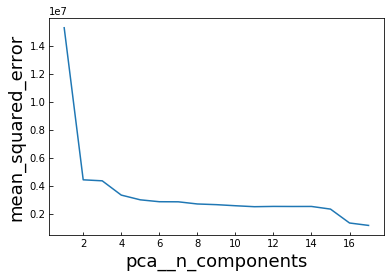

In [22]:
plt.plot(np.arange(1,18),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("pca__n_components", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [23]:
grid_search.best_params_

{'pca__n_components': 17}

In [24]:
y_predictions_pca = grid_search.predict(X_test_Standard)
lin_mse = mean_squared_error(y_test, y_predictions_pca)
lin_mse

1452824.8190075345

n=17时相当于OLS

**(f) Fit a PLS model on the training set, with M chosen by cross-
validation. Report the test error obtained, along with the value
of M selected by cross-validation.**

In [25]:
from sklearn.cross_decomposition import PLSRegression
np.random.seed(1)
param_grid = [
{'n_components': np.arange(1,18) },
]
pls = PLSRegression()
grid_search = GridSearchCV(pls, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=PLSRegression(copy=True, max_iter=500, n_components=2,
                                     scale=True, tol=1e-06),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

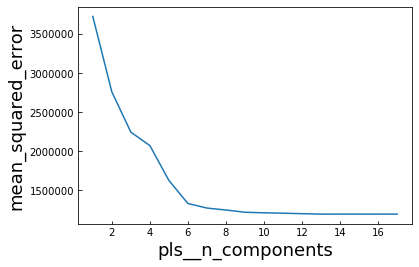

In [26]:
plt.plot(np.arange(1,18),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("pls__n_components", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [27]:
grid_search.best_params_

{'n_components': 13}

In [28]:
y_predictions_pls = grid_search.predict(X_test_Standard)
lin_mse = mean_squared_error(y_test, y_predictions_pls)
lin_mse

1446638.622866624

**(g) Comment on the results obtained. How accurately can we pre-
dict the number of college applications received? Is there much
difference among the test errors resulting from these five ap-
proaches?**

In [29]:
from sklearn.metrics import r2_score
r2_ols = r2_score(y_test, y_predictions_ols)
r2_ridge = r2_score(y_test, y_predictions_ridge)
r2_lasso = r2_score(y_test, y_predictions_lasso)
r2_pca = r2_score(y_test, y_predictions_pca)
r2_pls = r2_score(y_test, y_predictions_pls)

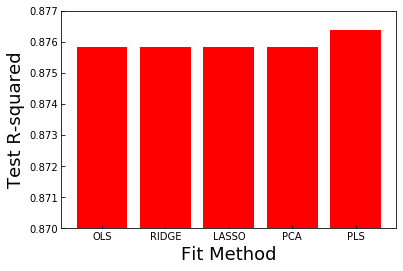

In [30]:
method_list = ['OLS','RIDGE','LASSO','PCA','PLS']
R2_list = [r2_ols,r2_ridge,r2_lasso,r2_pca,r2_pls]
plt.bar(method_list,R2_list,color = 'red')
plt.ylim(0.87,0.877)
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Test R-squared", fontsize=18)
plt.show()

PLS略微好于其他方案